In [53]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization, Bidirectional, RepeatVector, TimeDistributed, Add
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from diagnose import evaluate_forecasts



warnings.filterwarnings("ignore")

### CONFIGHERE ###

In [54]:
data_cutoff = -32
figsize=(12, 6)
train_size = 0.6


## 1. Eksploracja Dancych




## Opis danych

Zbiór danych składa się z jednej zmiennej finansowej zawierającej kwartalne obserwacje:

### **Net Income / Loss (wartość liczbowa, dane kwartalne)**  
Zmienna ta przedstawia zysk netto lub stratę netto osiąganą przez przedsiębiorstwo w każdym kwartale. Jest to kluczowy wskaźnik rentowności, wykorzystywany do analizy:

- efektywności finansowej w czasie,
- trendów wzrostu lub spadku wyników,
- sezonowości i cykliczności działalności,
- stabilności finansowej przedsiębiorstwa,
- identyfikacji potencjalnych czynników ryzyka.

Dane mają postać **szeregu czasowego**, w którym wartości są ułożone chronologicznie i występują w równych odstępach czasowych (co kwartał). Dzięki temu zmienna nadaje się do modelowania metodami prognostycznymi, takimi jak ARIMA, SARIMA, modele wygładzania wykładniczego, modele hybrydowe oraz algorytmy uczenia maszynowego.

---


In [55]:
df = pd.read_csv(r'Amazon Net Income by Quarter.csv')
df = df.head(data_cutoff)
real_case_data = df.copy().tail(data_cutoff)
df['Category'] = df['Category'].str.strip()

period_strings = df['Category'].str.replace(r'Q([1-4])\s*(\d{4})', r'\2Q\1', regex=True)

period_idx = pd.PeriodIndex(period_strings, freq='Q')

df.index = period_idx.to_timestamp()           

df.index.name = 'Date'  

df = df.drop(columns=['Category'])

#covid_start = "2020-03-01"
#covid_end = "2021-06-01"

#df = df.loc[~((df.index >= covid_start) & (df.index <= covid_end))]

In [56]:
df.describe()


,Net Income/Loss
count,83.000000
mean,73.662651
std,232.279493
min,-545.000000
25%,-29.000000
50%,73.000000
75%,194.000000
max,857.000000


In [57]:

fig = px.bar(df.reset_index(),
             x='Date',
             y='Net Income/Loss',
             title='Amazon Net Income by Quarter',
             labels={'Net Income/Loss':'Net Income (in Billions)','Date':'Quarter'})

fig.update_traces(marker_color='steelblue', showlegend=False)
fig.update_layout(xaxis_tickformat='%Y-%m', xaxis_tickangle=-45)
fig.show()


## Analiza Dystrybucji

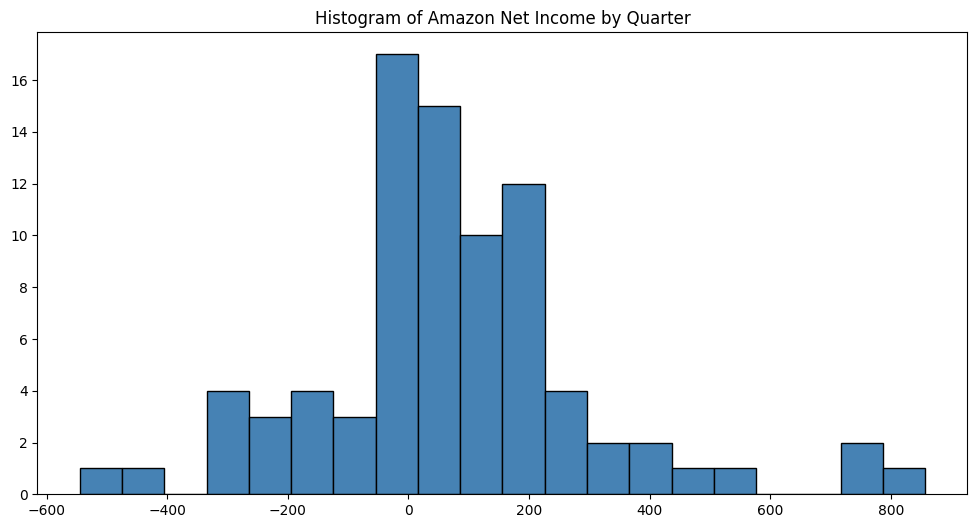

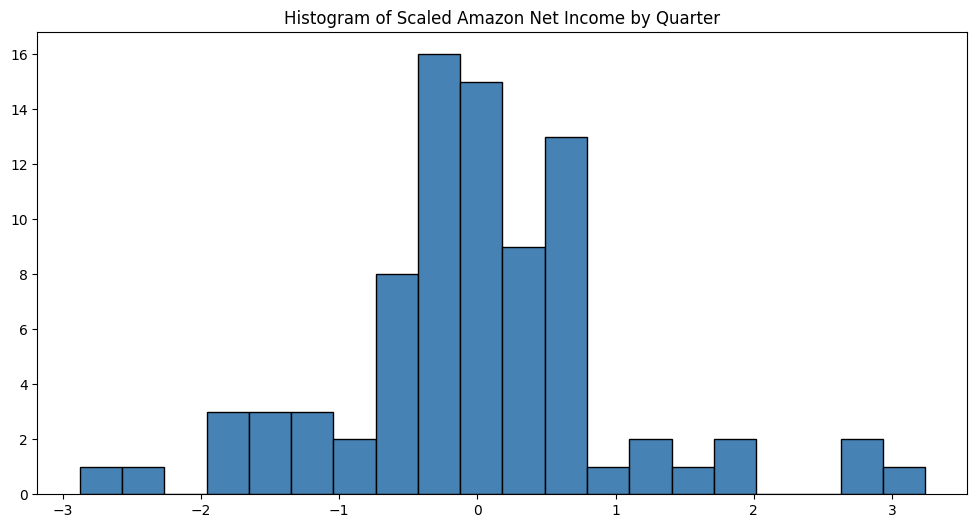

In [58]:
plt.figure(figsize=figsize)
plt.hist(df['Net Income/Loss'], bins=20, color='steelblue', edgecolor='black')
plt.title('Histogram of Amazon Net Income by Quarter')
plt.show()

pt = PowerTransformer(method='yeo-johnson')
scaled_data = pt.fit_transform(df)
plt.figure(figsize=figsize)
plt.hist(scaled_data, bins=20, color='steelblue', edgecolor='black')
plt.title('Histogram of Scaled Amazon Net Income by Quarter')
plt.show()
scaled_data = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)

dfs = [df, scaled_data]

## 2. Tesotwanie stacjonarności 


**Szereg czasowy stacjonarny** to taki szereg, którego własności statystyczne pozostają stałe w czasie.  
Oznacza to, że:

- **wartość oczekiwana (średnia)** jest stała,
- **wariancja** jest stała (nie zależy od czasu),
- **kowariancja/autokowariancja** zależy wyłącznie od opóźnienia (lag), a nie od konkretnego momentu czasu.

W praktyce szereg stacjonarny nie wykazuje trendu ani systematycznych zmian zmienności, a jego struktura statystyczna nie zmienia się wraz z upływem czasu.


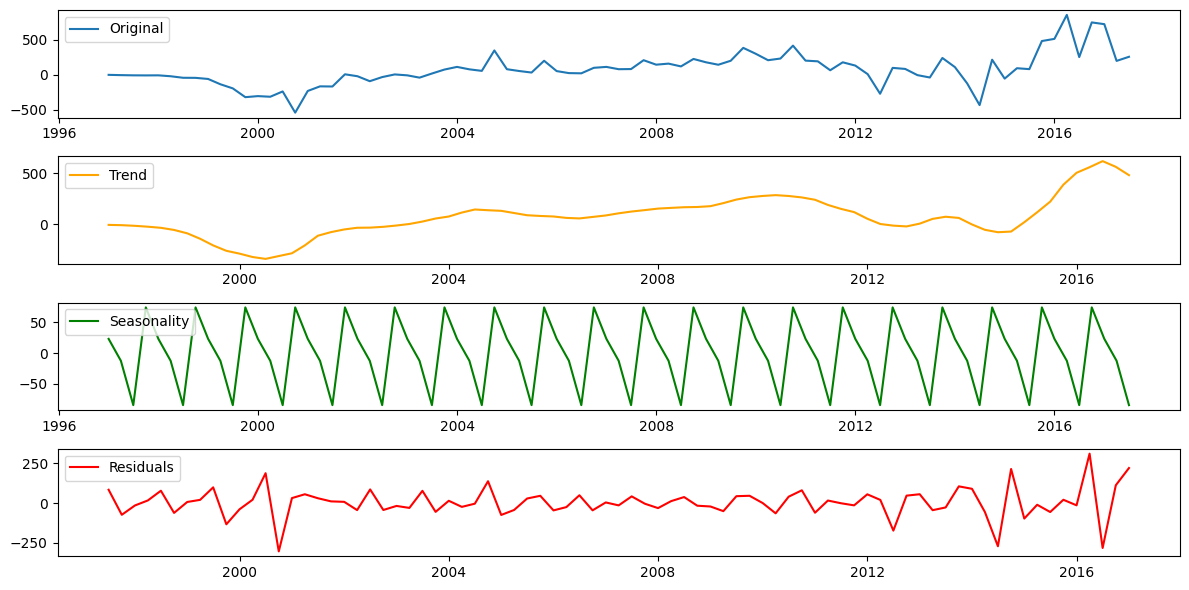

In [59]:
y_basic = df["Net Income/Loss"]

decomposition = seasonal_decompose(y_basic, model='additive', period=4)  

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.figure(figsize=figsize)

plt.subplot(411)
plt.plot(y_basic, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Detrending

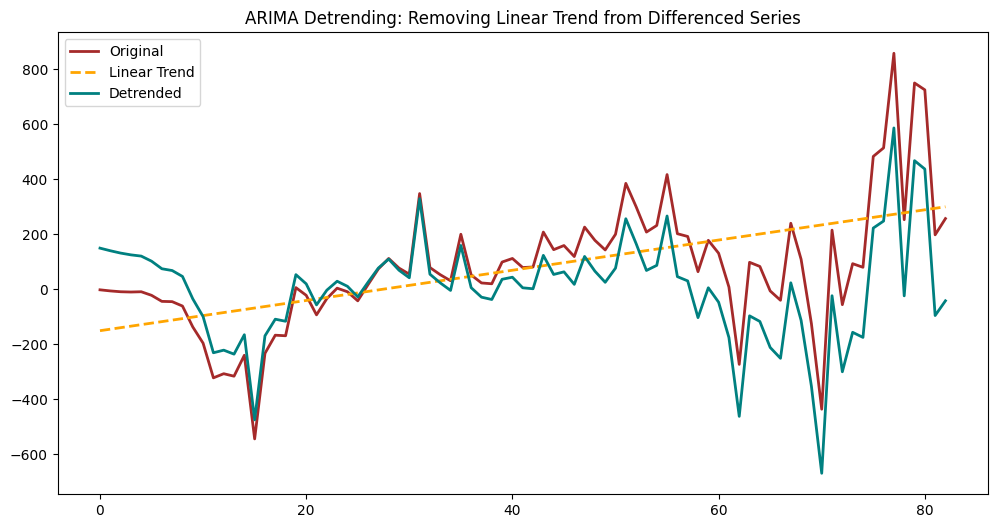

Original differenced series std: 232.2795
Detrended series std: 190.8359


In [60]:
from scipy import signal
y_d = df["Net Income/Loss"].copy()

y_detrended_vals = signal.detrend(df["Net Income/Loss"].values, type='linear')

x = np.arange(len(y_d))
z = np.polyfit(x, df["Net Income/Loss"].values, 1)
trend_line = z[0] * x + z[1]

y_detrended = pd.Series(y_detrended_vals, index=df["Net Income/Loss"].index)

plt.figure(figsize=figsize)
plt.plot(y_d.values, label='Original', alpha=1, color = 'brown', linewidth=2)
plt.plot(trend_line, label='Linear Trend', linestyle='--', linewidth=2, color ='orange')
plt.plot(y_detrended.values, label='Detrended', alpha=1, color='teal', linewidth=2)
plt.title('ARIMA Detrending: Removing Linear Trend from Differenced Series')
plt.legend()
plt.show()

print(f"Original differenced series std: {y_d.std():.4f}")
print(f"Detrended series std: {y_detrended.std():.4f}")

dfs.append(y_detrended)

### Testy Statystyczne


In [61]:
from diagnose import kpss_test, adf_test, zivot_andrews_test


kpss_test(y_detrended, regression='c')
adf_test(y_detrended)
zivot_andrews_test(y_detrended)


KPSS Statistic: 0.07415441351660584
p-value: 0.1
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Conclusion: Stationary


==== Augmented Dickey-Fuller Test ====
ADF Statistic : -2.7165456682498155
p-value       : 0.07121864648940224
Critical Values:
   1% : -3.5232835753964475
   5% : -2.902030597326081
   10% : -2.5883710883843123
Conclusion: Non-stationary


==== Zivot–Andrews Test (structural break) ====
Test Statistic : -3.797107816874394
p-value        : 0.48095663951506956
Break at index : {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618}
Critical Values:
   Critical values not provided in dictionary form.
Conclusion: Non-stationary




In [62]:
kpss_test(y_detrended.diff().dropna(), regression='c')

adf_test(y_detrended.diff().dropna())

zivot_andrews_test(y_detrended.diff().dropna())



KPSS Statistic: 0.08990827868460179
p-value: 0.1
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Conclusion: Stationary


==== Augmented Dickey-Fuller Test ====
ADF Statistic : -5.298350769866576
p-value       : 5.518890115735547e-06
Critical Values:
   1% : -3.520713130074074
   5% : -2.9009249540740742
   10% : -2.5877813777777776
Conclusion: Stationary


==== Zivot–Andrews Test (structural break) ====
Test Statistic : -6.285800616828331
p-value        : 0.0005282500675485068
Break at index : {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618}
Critical Values:
   Critical values not provided in dictionary form.
Conclusion: Stationary






**Wniosek:**  
Na podstawie wyników testów stacjonarności można stwierdzić, że zastosowanie pierwszego różnicowania (**d = 1**) jest odpowiednie dla analizowanego szeregu czasowego w modelu ARIMA.  
Pierwsze różnicowanie skutecznie eliminuje niestacjonarność, stabilizując średnią i umożliwiając poprawne modelowanie procesów autoregresyjnych.


## 3. Wybór optymalnych parametrów do modelu ARIMA

**Grid Search for Optimal (p, d, q) Parameters**
- **p**: AR order (1-4)
- **d**: Differencing order (0-1) 
- **q**: MA order (1-4)

Selection criterion: **AIC (Akaike Information Criterion)** - lower is better

In [63]:
results = []

max_p = 4
max_d = 1
max_q = 4

for i, data_series in enumerate(dfs):
    for p in range(1, max_p+1):
        for d in range(1, max_d+1):
            for q in range(1, max_q+1):
                order = (p, d, q)
                try:
                    model = ARIMA(data_series, order=order, enforce_invertibility=False, enforce_stationarity=False)
                    model_fit = model.fit()

                    results.append({
                        "dataset": f"Data {i}",
                        "p": p,
                        "d": d,
                        "q": q,
                        "AIC": model_fit.aic,
                        "BIC": model_fit.bic
                    })

                except:
                    continue

results_df = pd.DataFrame(results)
best_orders = {}
for dataset in results_df['dataset'].unique():
    best = results_df[results_df['dataset'] == dataset].sort_values("AIC").iloc[0]  
    print(f"\nBest ARIMA model for {dataset}:")
    print(f"Order: ({best['p']}, {best['d']}, {best['q']})  AIC: {best['AIC']:.2f}  BIC: {best['BIC']:.2f}")
    best_orders[dataset] = (best['p'], best['d'], best['q'])



Best ARIMA model for Data 0:
Order: (3, 1, 4)  AIC: 999.00  BIC: 1017.75

Best ARIMA model for Data 1:
Order: (3, 1, 3)  AIC: 161.61  BIC: 178.10

Best ARIMA model for Data 2:
Order: (4, 1, 4)  AIC: 996.49  BIC: 1017.58



Rolling Forecast ARIMA on Data 0:


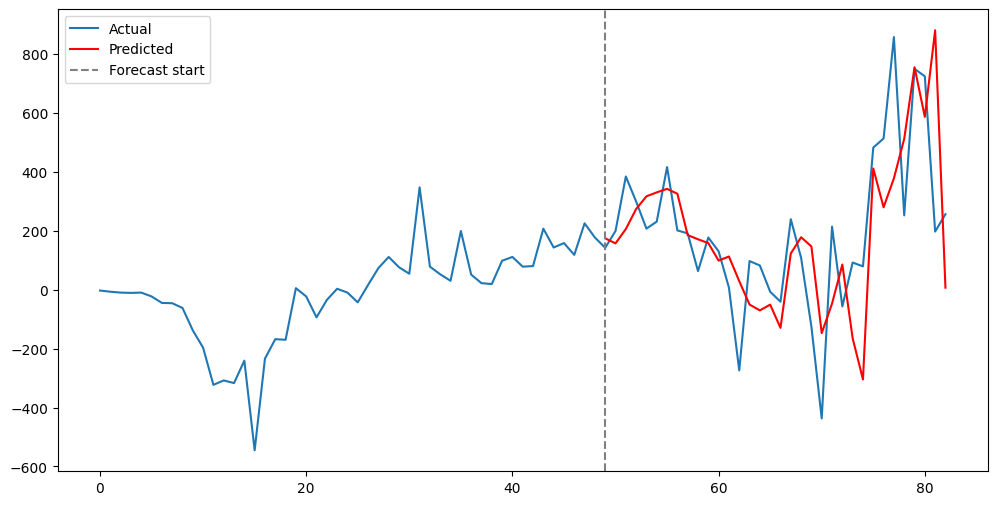

MAE: 164.75128193758928
RMSE: 219.04118037660615
sMAPE (%): 93.96151276248929
MASE: 0.845634292101558
R² Score: 0.29418364971467514
__________________________________

Rolling Forecast ARIMA on Data 1:


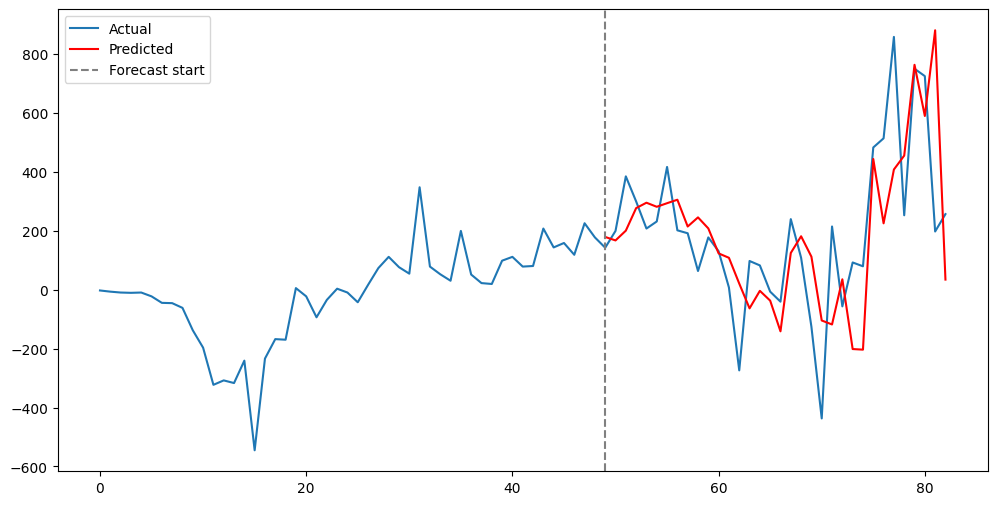

MAE: 160.18535009167877
RMSE: 215.59412399678536
sMAPE (%): 93.21423868872634
MASE: 0.8214067649593313
R² Score: 0.31622374964025546
__________________________________

Rolling Forecast ARIMA on Data 2:


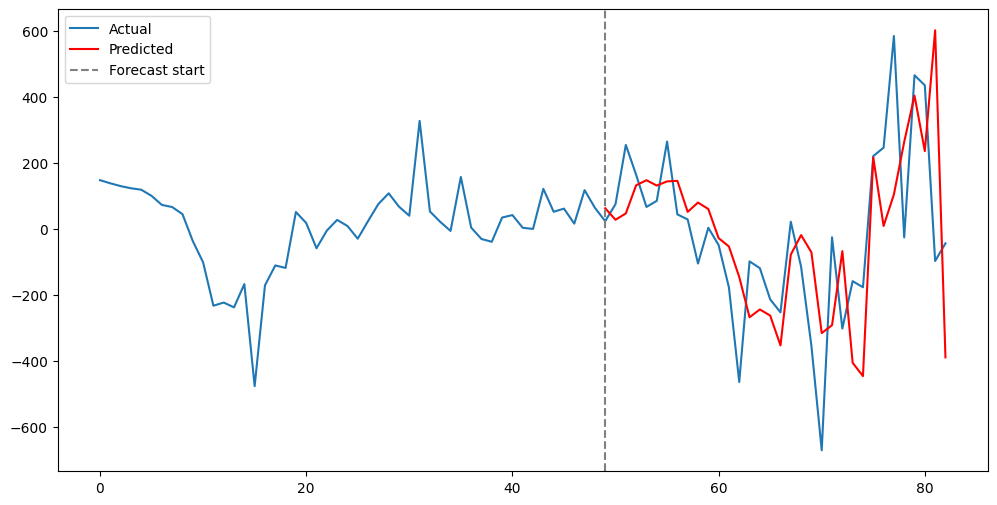

MAE: 176.94107527320702
RMSE: 230.16228003166654
sMAPE (%): 103.44626016317436
MASE: 0.9037320700855322
R² Score: 0.1723443362641206
__________________________________


In [64]:
from diagnose import rolling_forecast_arima
start_index = int(train_size * len(dfs[0]))

predictions = []
metrics_list = []
for i in range(3):
    print(f"\nRolling Forecast ARIMA on Data {i}:")
    best_row = best_orders[f'Data {i}']

    train = dfs[i][:start_index].values
    test = dfs[i][start_index:].values
    if i == 1:
        forcast = rolling_forecast_arima(train, test, best_row, start_index, dfs[i], scaler=pt)
        predictions.append(forcast["Predictions"])
        metrics_list.append(forcast["Metrics"])
    else:
        forcast = rolling_forecast_arima(train, test, best_row, start_index, dfs[i], scaler=None)
        predictions.append(forcast["Predictions"])
        metrics_list.append(forcast["Metrics"])

## Prophet

In [76]:
from prophet import Prophet

train_data = df.iloc[:start_index].copy()
test_data = df.iloc[start_index:].copy()
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
train_data_scaled = pd.DataFrame(train_data_scaled, index=df.index[:start_index], columns=df.columns)
test_data_scaled = scaler.transform(test_data)
test_data_scaled = pd.DataFrame(test_data_scaled, index=df.index[start_index:], columns=df.columns)

train_prophet = train_data_scaled.reset_index().rename(columns={'Date': 'ds', 'Net Income/Loss': 'y'})
test_prophet_dates = test_data_scaled.reset_index()['Date']
test_prophet = test_data_scaled.reset_index().rename(columns={'Date': 'ds', 'Net Income/Loss': 'y'})

history = train_prophet.copy()
pred_prophet = []

for t in range(len(test_prophet)):
    model = Prophet(daily_seasonality=False, yearly_seasonality=False, weekly_seasonality=False)
    model.fit(history)
    
    future = model.make_future_dataframe(periods=1, freq='D')
    forecast = model.predict(future)
    yhat = forecast['yhat'].iloc[-1]
    pred_prophet.append(yhat)
    
    new_row = test_prophet.iloc[[t]]
    history = pd.concat([history, new_row], ignore_index=True)

pred_prophet = np.array(pred_prophet).reshape(-1, 1)
pred_prophet = scaler.inverse_transform(pred_prophet)

test_prophet_values = scaler.inverse_transform(test_prophet['y'].values.reshape(-1, 1))


15:59:45 - cmdstanpy - INFO - Chain [1] start processing
15:59:45 - cmdstanpy - INFO - Chain [1] done processing
15:59:45 - cmdstanpy - INFO - Chain [1] start processing
15:59:45 - cmdstanpy - INFO - Chain [1] done processing
15:59:45 - cmdstanpy - INFO - Chain [1] start processing
15:59:45 - cmdstanpy - INFO - Chain [1] done processing
15:59:46 - cmdstanpy - INFO - Chain [1] start processing
15:59:46 - cmdstanpy - INFO - Chain [1] done processing
15:59:46 - cmdstanpy - INFO - Chain [1] start processing
15:59:46 - cmdstanpy - INFO - Chain [1] done processing
15:59:46 - cmdstanpy - INFO - Chain [1] start processing
15:59:46 - cmdstanpy - INFO - Chain [1] done processing
15:59:46 - cmdstanpy - INFO - Chain [1] start processing
15:59:46 - cmdstanpy - INFO - Chain [1] done processing
15:59:46 - cmdstanpy - INFO - Chain [1] start processing
15:59:47 - cmdstanpy - INFO - Chain [1] done processing
15:59:47 - cmdstanpy - INFO - Chain [1] start processing
15:59:47 - cmdstanpy - INFO - Chain [1]

In [77]:
test_prophet_values = pd.Series(test_prophet_values.flatten())
pr_metrics = evaluate_forecasts(test_prophet_values, pred_prophet.flatten())

MAE: 190.61379484091316
RMSE: 261.4276896550967
sMAPE (%): 83.67560299461941
MASE: 0.9814816940305955
R² Score: -0.005410327807811699


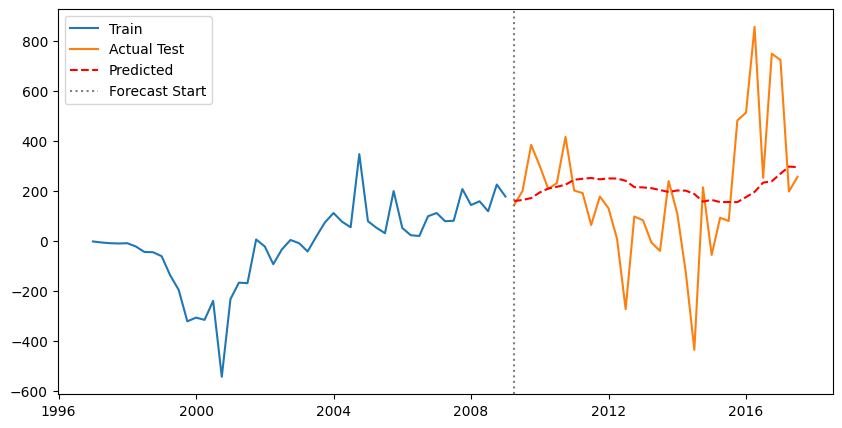

In [78]:

plt.figure(figsize=(10,5))
plt.plot(train_prophet['ds'], train_data, label='Train')
plt.plot(test_prophet['ds'], test_prophet_values, label='Actual Test')
plt.plot(test_prophet['ds'], pred_prophet, color='red', linestyle='--', label='Predicted')
plt.axvline(test_prophet['ds'].iloc[0], color='gray', linestyle=':', label='Forecast Start')
plt.legend()
plt.show()

In [79]:
import plotly.graph_objects as go
x_start = 0 
x_pred = list(range(x_start, x_start + len(pred_prophet)))  


fig = go.Figure()

fig.add_trace(go.Scatter(
    y=test,
    mode='lines',
    name='Actual Test',
    line=dict(color='black')
))

fig.add_trace(go.Scatter(
    x=x_pred,
    y=pred_prophet.flatten(),
    mode='lines',
    name='Predicted Prophet',
    line=dict(color='blue', dash='dash')
))

fig.add_trace(go.Scatter(
    y=predictions[0],
    mode='lines',
    name='Predicted ARIMA',
    line=dict(color='red', dash='dash')
))

fig.add_trace(go.Scatter(
    y=predictions[1],
    mode='lines',
    name='Predicted ARIMA scaled',
    line=dict(color='teal', dash='dash')
))

fig.add_trace(go.Scatter(
    y=predictions[2],
    mode='lines',
    name='Predicted ARIMA trend removed',
    line=dict(color='green', dash='dash')
))


fig.update_layout(
    title="ARIMA vs Prophet",
    xaxis_title="Time Index",
    yaxis_title="Net Income/Loss",
    template="plotly_white"
)


fig.show()

In [80]:


models_metrics = {
    'Prophet': pr_metrics,
    'ARIMA': metrics_list[0],
    'ARiMA Scaled': metrics_list[1],
    'ARIMA Trend Removed': metrics_list[2]
}

df_metrics = pd.DataFrame(models_metrics).T  
df_metrics = df_metrics.round(2)     
df_metrics
df_metrics.style.highlight_min(subset=['MAE','RMSE','SMAPE','MASE'], color='green')\
                .highlight_max(subset=['R^2'], color='green')

,MAE,RMSE,SMAPE,MASE,R^2
Prophet,190.610000,261.430000,83.680000,0.980000,-0.010000
ARIMA,164.750000,219.040000,93.960000,0.850000,0.290000
ARiMA Scaled,160.190000,215.590000,93.210000,0.820000,0.320000
ARIMA Trend Removed,176.940000,230.160000,103.450000,0.900000,0.170000
